## In what context were the states before the intervention of the incentive?

In [1]:
import numpy as np
import pandas as pd

states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

# On supprime le New Hampshire à cause d'irrégularités dans ses données vaccinales

states_names = {"AL":"Alabama", "AK":"Alaska", "AZ":"Arizona", "AR":"Arkansas",
                "CA":"California", "CO":"Colorado", "CT":"Connecticut",
                "DE":"Delaware", "FL":"Florida", "GA":"Georgia", "HI":"Hawaii",
                "ID":"Idaho", "IL":"Illinois", "IN":"Indiana", "IA":"Iowa",
                "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine",
                "MD":"Maryland", "MA":"Massachusetts", "MI":"Michigan",
                "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana",
                "NE":"Nebraska", "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey",
                "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
                "ND":"North Dakota", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon",
                "PA":"Pennsylvania", "RI":"Rhode Island", "SC":"South Carolina",
                "SD":"South Dakota", "TN":"Tennessee", "TX":"Texas", "UT":"Utah",
                "VT":"Vermont", "VA":"Virginia", "WA":"Washington", "WV":"West Virginia",
                "WI":"Wisconsin", "WY":"Wyoming"}

In [32]:
df_states = {}
for X in states:
  # fichiers csv à trouver dans le drive partagé
    path = 'state_vax_csv/'+X+'.csv'
    df_states[X] = pd.read_csv(path, sep=',')
    df_states[X] = df_states[X].loc[::-1].reset_index(drop=True)
    df_states[X] = df_states[X].loc[67:,:].reset_index(drop=True)

In [12]:
# On remarque qu'il y a des problèmes dans le report des doses administrées : il arrive que le pourcentage de doses
# administrées diminue, alors qu'il ne devrait qu'augmenter ou rester constant (cf. explications dans le rapport)
# On décide donc de remédier à ces erreurs en fixant un seuil pour éviter que les données ne diminuent
# Dans un second temps, on effectue une interpolation sur la période où l'on constate des erreurs de report

tf = len(df_states['CA'])

for seg in ["Administered_Dose1_Pop_Pct", "Administered_Dose1_Recip_12_17_Pct", "Administered_Dose1_Recip_18_64_Pct", "Administered_Dose1_Recip_65PlusPop_Pct"]:
    for state in states:
        for t in range(1,tf):
            if df_states[state].loc[t, seg] < df_states[state].loc[t-1, seg]:
                #on a un souci à partir du temps t
                j = t
                flag = True
                while j < tf and flag:
                    if df_states[state].loc[j, seg] >= df_states[state].loc[t-1, seg]:
                        #on a trouvé le plus petit indice pour lequel les données redeviennent cohérentes
                        a_t = df_states[state].loc[t-1, seg]
                        a_j = df_states[state].loc[j, seg]
                        
                        #on interpole linéairement
                        for i in range(t,j):
                            df_states[state].loc[i, seg] = ((a_t-a_j)/(t-1-j))*(i-j) + a_j
                        flag = False
                    j +=1 
                        
                if flag:
                    #on a pas trouvé de plus petit indice: on crée un plateau à partir du temps t
                    for i in range(t,tf):
                        df_states[state].loc[i, seg] = df_states[state].loc[t-1, seg]

In [88]:
# On s'intéresse à la colonne du pourcentage de personnes ayant reçu au moins une dose. 
# C'est notre "response variable" que l'on cherche à modéliser après l'intervention.

df_dose1 = {"Pop":{} ,"12-17":{}, "18-64":{}, "65Plus":{}}
df_admin = {}

for X in states:
    df_dose1["Pop"][X] = df_states[X].loc[:,'Administered_Dose1_Pop_Pct']
    df_dose1["12-17"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_12_17_Pct']
    df_dose1["18-64"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_18_64_Pct']
    df_dose1["65Plus"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_65PlusPop_Pct']
    df_admin[X] = df_states[X].loc[:,'Admin_Per_100K']

ls_dose1 = {"Pop":{} ,"12-17":{}, "18-64":{}, "65Plus":{}}
for k in ["Pop", "12-17", "18-64", "65Plus"]:
    for X in states:
        ls_dose1[k][X] = df_dose1[k][X].to_numpy()

In [14]:
df_prm = pd.read_excel('parameters.xlsx', 'By state code', index_col=0)
df_prm = df_prm.drop(columns=['Population'])
prm = df_prm.to_numpy()
    
state_vector = {}
for i in range(len(states)):
    state_vector[states[i]] = prm[i]

In [15]:
# Normalisation et moyenne à 0

df_prm_scaled = (df_prm-df_prm.mean())/df_prm.std()
prm_scaled = df_prm_scaled.to_numpy()

state_vector_scaled = {}
for i in range(len(states)):
    state_vector_scaled[states[i]] = prm_scaled[i]

In [16]:
incentives = pd.read_csv('incentive_list_updated.csv', index_col=None)

target_states_all = set(incentives["State code"])
control_states_all = []
for X in states:
  if X not in target_states_all:
    control_states_all.append(X)
    
control_states_names = [states_names[X] for X in control_states_all]

In [38]:
dates = {}
category = {}
for X in target_states_all:
    dates[X] = incentives.loc[incentives["State code"] == X, "Incentive t0"]
    dates[X] = dates[X].iloc[0]

In [50]:
import datetime
inc_t0 = {}
inc_t0["Pop"] = {}
inc_t0["18-64"] = {}
inc_t0["65Plus"] = {}

for X in target_states_all:
  # 19/02/2021 approx première date à laquelle les taux de vaccination sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates[X]
  t0_date = datetime.date(int(t0_date_str[6:]), int(t0_date_str[3:5]), int(t0_date_str[0:2]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0["Pop"][X] = t0
  inc_t0["18-64"][X] = t0
  inc_t0["65Plus"][X] = t0

2021-06-08


Text(0.5, 1.0, '1st dose, 7 day growth before intervention')

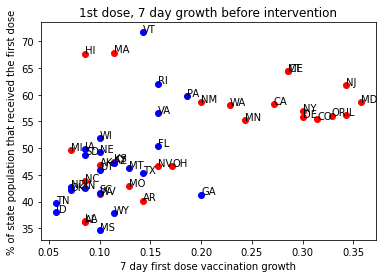

In [89]:
import matplotlib.pyplot as plt

t_avg = 0
for X in target_states_all:
    t_avg += inc_t0["Pop"][X]/len(target_states_all)
t_avg = round(t_avg)
print(start+datetime.timedelta(days=t_avg))
# t_avg = min([inc_t0["Pop"][X] for X in target_states_all])
# t_avg = max([inc_t0["Pop"][X] for X in target_states_all])

evo_before_target = {X:((df_dose1["Pop"][X].iloc[inc_t0["Pop"][X]]-df_dose1["Pop"][X].iloc[inc_t0["Pop"][X]-7])/7,df_dose1["Pop"][X].iloc[t_avg]) for X in target_states_all}
# evo_before_target = {X:((df_dose1["Pop"][X].iloc[t_avg]-df_dose1["Pop"][X].iloc[t_avg-7])/7,df_dose1["Pop"][X].iloc[t_avg]) for X in target_states_all}
evo_before_control = {X:((df_dose1["Pop"][X].iloc[t_avg]-df_dose1["Pop"][X].iloc[t_avg-7])/7,df_dose1["Pop"][X].iloc[t_avg]) for X in control_states_all}

for i in evo_before_target:
    (x, y) = evo_before_target.get(i)
    plt.scatter(x, y, color="red")
    plt.text(x=x, y=y, s=i)

for i in evo_before_control:
    (x, y) = evo_before_control.get(i)
    plt.scatter(x, y, color="blue")
    plt.text(x=x, y=y, s=i)

plt.xlabel('7 day first dose vaccination growth')
plt.ylabel('% of state population that received the first dose')
plt.title('1st dose, 7 day growth before intervention')


Text(0.5, 1.0, '1st dose, 7 day growth post intervention')

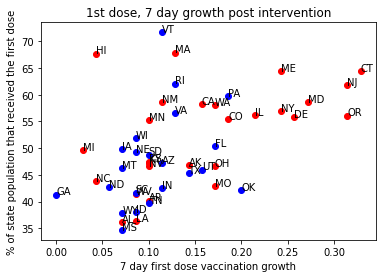

In [94]:
evo_after_target = {X:((df_dose1["Pop"][X].iloc[inc_t0["Pop"][X]+7]-df_dose1["Pop"][X].iloc[inc_t0["Pop"][X]])/7,df_dose1["Pop"][X].iloc[t_avg]) for X in target_states_all}
# evo_after_target = {X:((df_dose1["Pop"][X].iloc[t_avg+7]-df_dose1["Pop"][X].iloc[t_avg])/7,df_dose1["Pop"][X].iloc[t_avg]) for X in target_states_all}
evo_after_control = {X:((df_dose1["Pop"][X].iloc[t_avg+7]-df_dose1["Pop"][X].iloc[t_avg])/7,df_dose1["Pop"][X].iloc[t_avg]) for X in control_states_all}

for i in evo_after_target:
    (x, y) = evo_after_target.get(i)
    plt.scatter(x, y, color="red")
    plt.text(x=x, y=y, s=i)

for i in evo_after_control:
    (x, y) = evo_after_control.get(i)
    plt.scatter(x, y, color="blue")
    plt.text(x=x, y=y, s=i)

plt.xlabel('7 day first dose vaccination growth')
plt.ylabel('% of state population that received the first dose')
plt.title('1st dose, 7 day growth post intervention')

Text(0.5, 1.0, 'Administered doses, 7 day growth before intervention')

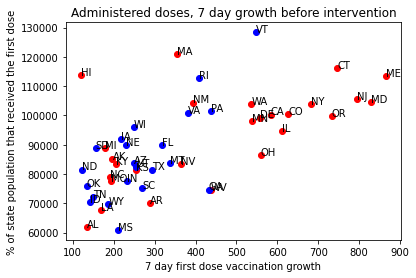

In [100]:
evo_after_target = {X:((df_admin[X].iloc[inc_t0["Pop"][X]]-df_admin[X].iloc[inc_t0["Pop"][X]-7])/7,df_admin[X].iloc[t_avg]) for X in target_states_all}
# evo_after_target = {X:((df_admin[X].iloc[t_avg]-df_admin[X].iloc[t_avg-7])/7,df_admin[X].iloc[t_avg]) for X in target_states_all}
evo_after_control = {X:((df_admin[X].iloc[t_avg]-df_admin[X].iloc[t_avg-7])/7,df_admin[X].iloc[t_avg]) for X in control_states_all}

for i in evo_after_target:
    (x, y) = evo_after_target.get(i)
    plt.scatter(x, y, color="red")
    plt.text(x=x, y=y, s=i)

for i in evo_after_control:
    (x, y) = evo_after_control.get(i)
    plt.scatter(x, y, color="blue")
    plt.text(x=x, y=y, s=i)

plt.xlabel('7 day first dose vaccination growth')
plt.ylabel('% of state population that received the first dose')
plt.title('Administered doses, 7 day growth before intervention')

Text(0.5, 1.0, 'Administered doses, 7 day growth post intervention')

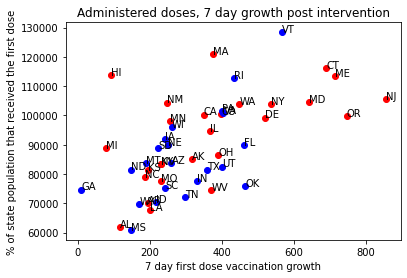

In [98]:
evo_after_target = {X:((df_admin[X].iloc[inc_t0["Pop"][X]+7]-df_admin[X].iloc[inc_t0["Pop"][X]])/7,df_admin[X].iloc[t_avg]) for X in target_states_all}
# evo_after_target = {X:((df_admin[X].iloc[t_avg+7]-df_admin[X].iloc[t_avg])/7,df_admin[X].iloc[t_avg]) for X in target_states_all}
evo_after_control = {X:((df_admin[X].iloc[t_avg+7]-df_admin[X].iloc[t_avg])/7,df_admin[X].iloc[t_avg]) for X in control_states_all}

for i in evo_after_target:
    (x, y) = evo_after_target.get(i)
    plt.scatter(x, y, color="red")
    plt.text(x=x, y=y, s=i)

for i in evo_after_control:
    (x, y) = evo_after_control.get(i)
    plt.scatter(x, y, color="blue")
    plt.text(x=x, y=y, s=i)

plt.xlabel('7 day first dose vaccination growth')
plt.ylabel('% of state population that received the first dose')
plt.title('Administered doses, 7 day growth post intervention')